Closed-Form RMSE: 5641.63
Gradient-Descent RMSE: 5641.63
sklearn RMSE: 5641.63


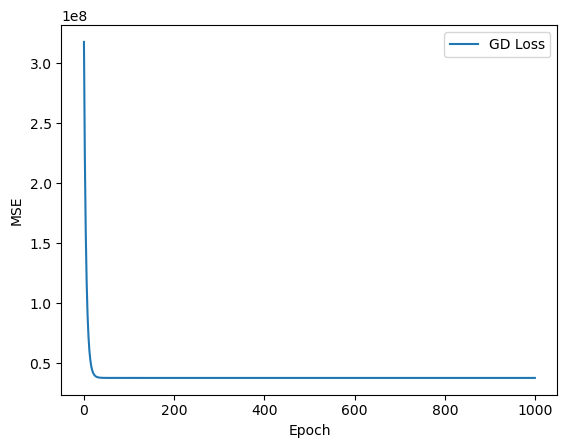

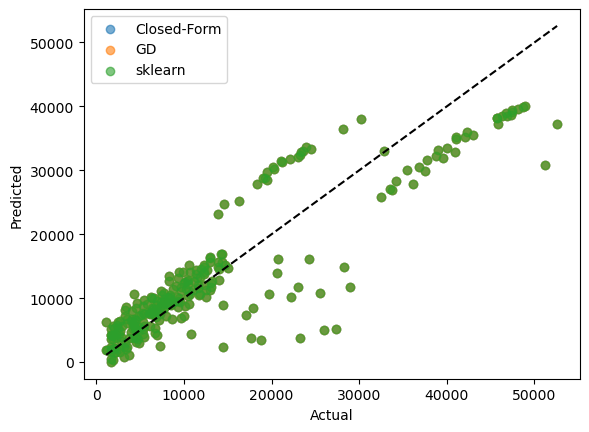

In [1]:

import pandas as pd
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df  = pd.read_csv(url)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
import numpy as np

# 1) One-hot encode
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)

# 2) Split
X = df.drop('charges',axis=1).values
y = df['charges'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# 3) Standardize
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 4) Add bias column
X_train_b = np.c_[np.ones((X_train_std.shape[0],1)), X_train_std]
X_test_b  = np.c_[np.ones((X_test_std.shape[0],1)),  X_test_std]

## Model 1: Closed-Form (Normal Equation)


# w = (X^T X)^{-1} X^T y
w_closed     = np.linalg.inv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train)
y_pred_closed = X_test_b @ w_closed


## Model 2: Gradient Descent


class LinearRegressionGD:
    def __init__(self, eta=0.01, epochs=500):
        self.eta, self.epochs = eta, epochs

    def fit(self, X, y):
        m, n = X.shape
        self.w_   = np.zeros((n,1))
        self.loss_ = []
        for _ in range(self.epochs):
            y_pred = X @ self.w_
            error  = y_pred - y
            mse    = (error**2).mean()
            self.loss_.append(mse)
            grad   = (2/m)*(X.T @ error)
            self.w_ -= self.eta * grad
        return self

    def predict(self, X):
        return X @ self.w_

gd = LinearRegressionGD(eta=0.05, epochs=1000).fit(X_train_b, y_train)
y_pred_gd = gd.predict(X_test_b)


## Model 3: scikit-learn’s LinearRegression


from sklearn.linear_model import LinearRegression
sk = LinearRegression(fit_intercept=False).fit(X_train_b, y_train)
y_pred_sk = sk.predict(X_test_b)

## Evaluation


from sklearn.metrics import mean_squared_error
for name, y_pred in [
    ("Closed-Form",      y_pred_closed),
    ("Gradient-Descent", y_pred_gd),
    ("sklearn",          y_pred_sk)
]:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} RMSE: {rmse:.2f}")

## Visualizations


import matplotlib.pyplot as plt

# Loss curve
plt.plot(gd.loss_, label="GD Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Predicted vs Actual
plt.scatter(y_test, y_pred_closed, label="Closed-Form", alpha=0.6)
plt.scatter(y_test, y_pred_gd,     label="GD",           alpha=0.6)
plt.scatter(y_test, y_pred_sk,     label="sklearn",      alpha=0.6)
plt.plot([y_test.min(),y_test.max()],
         [y_test.min(),y_test.max()],
         "k--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()




# Example 1: Linear Regression on Medical Insurance Charges

**Definition**  
Linear regression fits  
\[
\hat y = w_1 x + w_0
\]  
to minimize  
\(\displaystyle \sum_{i=1}^m(y_i - \hat y_i)^2\).  
We’ll measure accuracy via RMSE:
\[
\text{RMSE} = \sqrt{\frac1m\sum_i(y_i - \hat y_i)^2}.
\]

---

## Data  
- **Dataset:** “Medical Cost Personal” (`insurance.csv`), 1,338 records  
- **Features:** `age`, `sex` (0/1), `bmi`, `children`, `smoker` (0/1), `region` (one-hot)  
- **Target:** `charges` (annual medical cost)